In [1]:
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
import math
from scipy import stats
plt.rc("figure", figsize=(20,20))
plt.rc("font", size=14)
import os
from numpy import trapz

In [2]:
os.chdir('/Users/Ben/Desktop/optimal_decision_trees/evaluation')
holdout=pd.read_csv('/Users/Ben/Desktop/optimal_decision_trees/data/holdout.csv')
holdout_glm=pd.read_csv('/Users/Ben/Desktop/optimal_decision_trees/outputs/holdout_glm_predictions.csv')
holdout_glm.columns=['id', 'loss']
holdout_odt=pd.read_csv('/Users/Ben/Desktop/optimal_decision_trees/outputs/holdout_odt_predictions_maxdepth9.csv')
holdout_odt['loss']=holdout_odt['loss'].astype(float)
holdout_xgb=pd.read_csv('/Users/Ben/Desktop/optimal_decision_trees/outputs/holdout_xgb_predictions.csv')

# MAE

In [3]:
model_name=['glm', 'odt', 'xgb']
y_pred=[holdout_glm.loss, holdout_odt.loss, holdout_xgb.loss]
y_valid=holdout['loss']

for i,v in zip(model_name,y_pred):

    result=mean_absolute_error(v, y_valid)
    print(i, 'mae result: ', result)

glm mae result:  1605.1786064552384
odt mae result:  1298.5919033351881
xgb mae result:  1191.179014525903


glm kaggle mae result: 1604.37392 <br>
odt kaggle mae result: 1291.26808 <br>
xgb kaggle mae result: 1189.10807

# X-Graph

In [4]:
def create_xgraph(df_actual, df_model1, df_model2, col, model1, model2):

    ''' create xgraph comparison '''

    # dataframe joins
    xgraph=df_actual[['id', col]].merge(df_model2, on=['id'])\
    .merge(df_model1, on=['id'])
    xgraph.columns=['id', 'loss_actual', 'loss_model2', 'loss_model1']
    xgraph['Exposure']=1

    # create partitions
    xgraph['loss_actual_sum']=xgraph.groupby('Exposure')['loss_actual'].transform(sum)
    xgraph['loss_model2_sum']=xgraph.groupby('Exposure')['loss_model2'].transform(sum)
    xgraph['loss_model1_sum']=xgraph.groupby('Exposure')['loss_model1'].transform(sum)

    # rates
    xgraph['proposed_rat']=xgraph['loss_actual_sum']/xgraph['loss_model2_sum']
    xgraph['observed_rat']=xgraph['loss_actual_sum']/xgraph['loss_actual_sum']
    xgraph['curr_rat']=xgraph['loss_actual_sum']/xgraph['loss_model1_sum']

    # multiple by rat
    xgraph['prop_pr']=xgraph['loss_model2']*xgraph['proposed_rat']
    xgraph['curr_pr']=xgraph['loss_model1']*xgraph['curr_rat']
    xgraph['obs_pr']=xgraph['loss_actual']

    # create bins
    xgraph['diff']=xgraph['prop_pr']/xgraph['curr_pr']
    xgraph['diff_band']=pd.qcut(xgraph['diff'], 20).astype(str)

    # values for x-graph
    exposure=(xgraph.groupby('diff_band').sum()['Exposure']).to_list()
    prop=(xgraph.groupby('diff_band').sum()['prop_pr']/xgraph.groupby('diff_band').sum()['curr_pr']).to_list()
    curr=(xgraph.groupby('diff_band').sum()['curr_pr']/xgraph.groupby('diff_band').sum()['curr_pr']).to_list()
    obs=(xgraph.groupby('diff_band').sum()['obs_pr']/xgraph.groupby('diff_band').sum()['curr_pr']).to_list()
    diff_band=sorted(xgraph['diff_band'].unique())

    # Bar plot
    plt.rcParams["figure.figsize"] = (10,10)
    N=len(exposure)
    width = 0.5
    plt.bar(diff_band, exposure, width, color='gold', label='Diff', edgecolor='k')
    plt.xticks(rotation=90)
    plt.ylim(0, max(exposure)*3)
    plt.ylabel('Exposure')
    plt.xlabel(f'Model 2 ({model2})/ Model 1 ({model1})')
    plt.title(f'X-Graph showing a comparison between {model1} and {model2}')

    # Line plot
    axes2 = plt.twinx()
    axes2.plot(diff_band, obs, color='fuchsia', marker="s", markeredgecolor='black', label='Actual')
    axes2.plot(diff_band, prop, color='blue', marker="D", markeredgecolor='black', label=f'Model 2 ({model2})')
    axes2.plot(diff_band, curr, color='g', marker="^", markeredgecolor='black', label=f'Model 1 ({model1})')
    axes2.set_ylabel('Response')

    # legend and settings
    plt.legend(loc="upper left")

    plt.show()

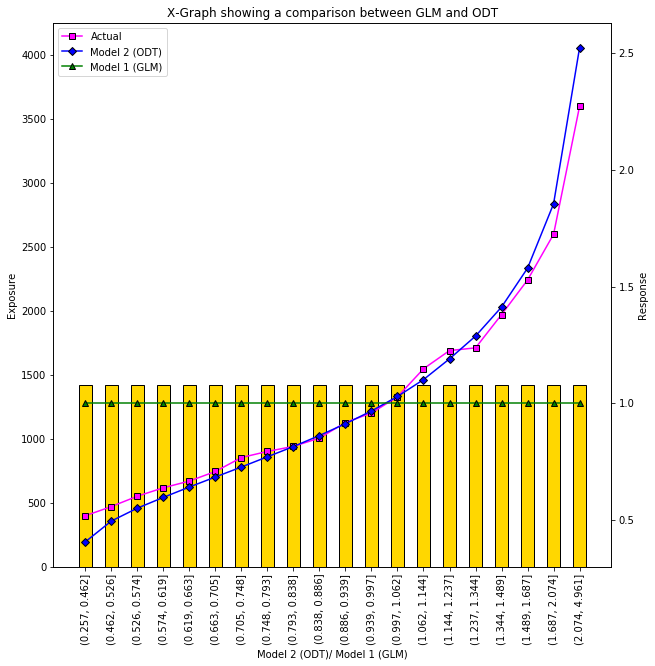

In [5]:
create_xgraph(holdout, holdout_glm, holdout_odt, 'loss', 'GLM', 'ODT')

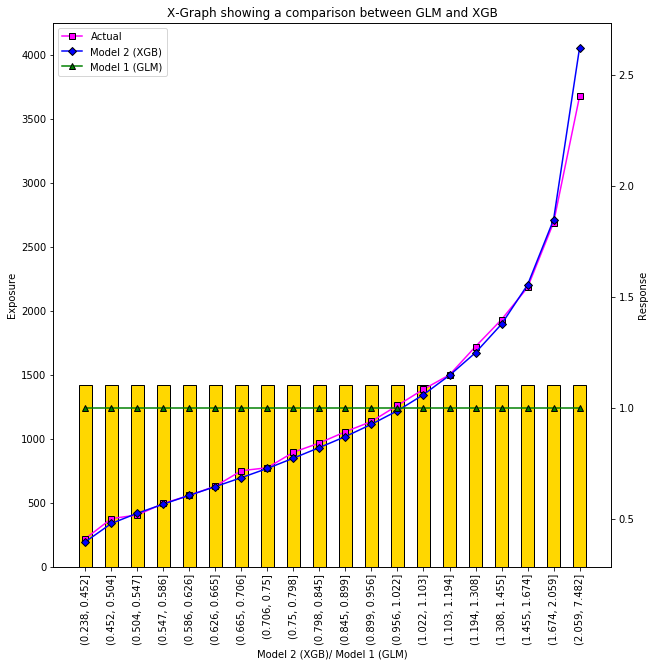

In [6]:
create_xgraph(holdout, holdout_glm, holdout_xgb, 'loss', 'GLM', 'XGB')

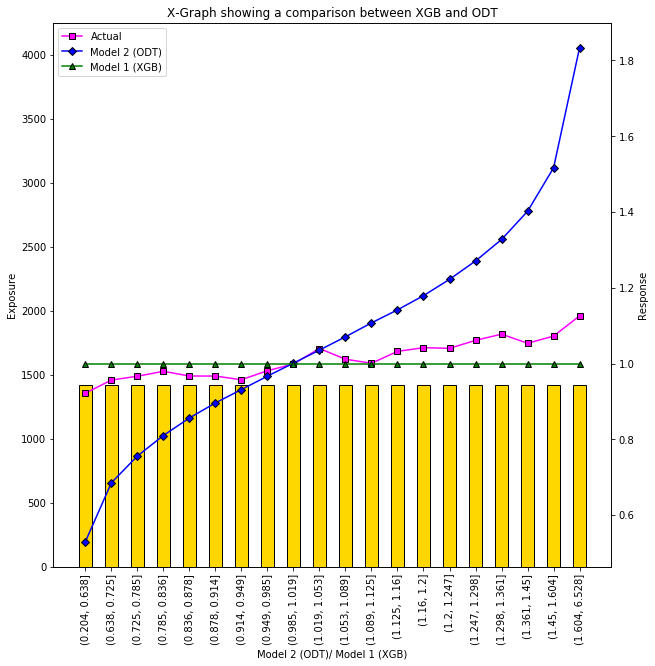

In [7]:
create_xgraph(holdout, holdout_xgb, holdout_odt, 'loss', 'XGB', 'ODT')

# GINI

In [8]:
def calc_gini_coef(pred, exp):

    '''Compute the area using the composite trapezoidal rule '''

    pred_area = trapz(pred, dx=len(pred))
    exp_area = trapz(exp, dx=len(exp))
    gini=round((pred_area/exp_area)-1,2)
    return gini


In [9]:
def create_gini_table(df, col, num):

    gini_df=df[[col]].sort_values(by=col, ascending=False)
    gini_df['exposure_bucket']=pd.qcut(gini_df[col], num).astype(str)
    gini_df['exposure']=1

    gini_df_grouped=gini_df.groupby('exposure_bucket').sum().reset_index()
    gini_df_grouped['exposure_bucket_rank']=gini_df_grouped['exposure_bucket'].str.slice(-9).str.replace("]","").str.replace(",","").astype(float)
    gini_df_grouped=gini_df_grouped.sort_values(by='exposure_bucket_rank', ascending=False)
    gini_df_grouped['pred_cumsum']=gini_df_grouped[col].cumsum()
    gini_df_grouped['pred_cumsum_per']=round((gini_df_grouped[col].cumsum()/gini_df_grouped[col].sum())*100,2)
    gini_df_grouped['exposure_cumsum']=gini_df_grouped['exposure'].cumsum()
    gini_df_grouped['exposure_cumsum_per']=round((gini_df_grouped['exposure_cumsum']/gini_df_grouped['exposure'].sum())*100,2)
    gini_df_grouped['count']=1
    gini_df_grouped['count_cumsum']=gini_df_grouped['count'].cumsum()

    return gini_df_grouped

In [10]:
def plot_gini_curve(bucket, exposure, exp, 
              model1, model1_df, model1_name,
              model2, model2_df, model2_name,
              model3, model3_df, model3_name,
              col):

    # Bar plot
    plt.rcParams["figure.figsize"] = (10,10)
#     N=len(exposure)
    width = 0.5
#     plt.bar(bucket, exposure, width, color='gold', label='Diff', edgecolor='k')
    #plt.xticks(rotation=90)
#     plt.ylim(0, max(exposure)*3)
    plt.ylabel('Cumulative %')
    plt.xlabel('Equal Exposure Buckets')
    plt.title(f'Gini Graph')

    model1_gini=calc_gini_coef(create_gini_table(model1_df, col, num)['pred_cumsum_per'], create_gini_table(model1_df, col, num)['exposure_cumsum_per'])
    model2_gini=calc_gini_coef(create_gini_table(model2_df, col, num)['pred_cumsum_per'], create_gini_table(model2_df, col, num)['exposure_cumsum_per'])
    model3_gini=calc_gini_coef(create_gini_table(model3_df, col, num)['pred_cumsum_per'], create_gini_table(model3_df, col, num)['exposure_cumsum_per'])

    # Line plot
#     axes2 = plt.twinx()
    plt.plot(bucket, exp, label='Exposures', color='fuchsia', marker="s", markeredgecolor='black')
    plt.plot(bucket, model1, label=f'{model1_name} - {model1_gini}', color='g', marker="^", markeredgecolor='black')
    plt.plot(bucket, model2, label=f'{model2_name} - {model2_gini}', color='blue', marker="D", markeredgecolor='black')
    plt.plot(bucket, model3, label=f'{model3_name} - {model3_gini}', color='red', marker="D", markeredgecolor='black')
#     axes2.set_ylabel('Cumulative %')

    # legend and settings
    plt.legend(loc="upper left")

    # plot
    plt.show()

In [11]:
def plot_gini(bucket, exposure, exp, 
              model1, model1_df, 
              model2, model2_df, 
              model3, model3_df, col):

    # Bar plot
    plt.rcParams["figure.figsize"] = (10,10)
#     N=len(exposure)
    width = 0.5
    plt.bar(bucket, exposure, width, color='gold', label='Diff', edgecolor='k')
    #plt.xticks(rotation=90)
    plt.ylim(0, max(exposure)*3)
    plt.ylabel('Exposure')
    plt.xlabel('Equal Exposure Buckets')
    plt.title(f'Gini Graph')

    model1_gini=calc_gini_coef(create_gini_table(model1_df, col, num)['pred_cumsum_per'], create_gini_table(model1_df, col, num)['exposure_cumsum_per'])
    model2_gini=calc_gini_coef(create_gini_table(model2_df, col, num)['pred_cumsum_per'], create_gini_table(model2_df, col, num)['exposure_cumsum_per'])
    model3_gini=calc_gini_coef(create_gini_table(model3_df, col, num)['pred_cumsum_per'], create_gini_table(model3_df, col, num)['exposure_cumsum_per'])

    # Line plot
    axes2 = plt.twinx()
    axes2.plot(bucket, exp, label='Exposures', color='fuchsia', marker="s", markeredgecolor='black')
    axes2.plot(bucket, model1, label=f'Model 1 - {model1_gini}', color='g', marker="^", markeredgecolor='black')
    axes2.plot(bucket, model2, label=f'Model 2 - {model2_gini}', color='blue', marker="D", markeredgecolor='black')
    axes2.plot(bucket, model3, label=f'Model 3 - {model3_gini}', color='red', marker="D", markeredgecolor='black')
    axes2.set_ylabel('Cumulative %')

    # legend and settings
    plt.legend(loc="upper left")

    # plot
    plt.show()

In [12]:
def add_zero(val):
    return pd.concat([pd.Series([0]), val])

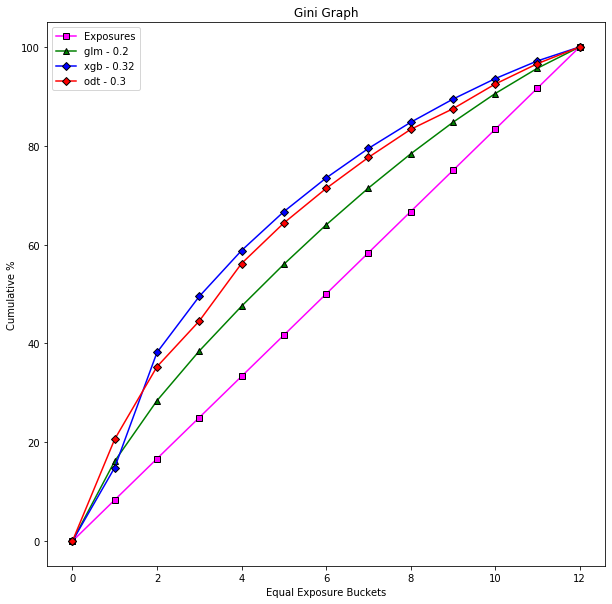

In [13]:
num=12
col='loss'
bucket=add_zero(create_gini_table(holdout_glm, col, num)['count_cumsum'])
exposure=add_zero(create_gini_table(holdout_odt, col, num)['exposure'])
exp=add_zero(create_gini_table(holdout_glm, col, num)['exposure_cumsum_per'])
glm=add_zero(create_gini_table(holdout_glm, col, num)['pred_cumsum_per'])
xgb=add_zero(create_gini_table(holdout_xgb, col, num)['pred_cumsum_per'])
odt=add_zero(create_gini_table(holdout_odt, col, num)['pred_cumsum_per'])

bucket=bucket.tolist()
plot_gini_curve(bucket, exposure, exp, 
                glm, holdout_glm, 'glm',
                xgb, holdout_xgb, 'xgb',
                odt, holdout_odt, 'odt',
                col)